In [17]:
# import libraries
import shap
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_roc_curve, classification_report

import json

from constants import *

import os

os.environ['QT_QPA_PLATFORM'] = 'offscreen'

sns.set()


In [18]:


df_cat_cols = [
    'Gender',
    'Education_Level',
    'Marital_Status',
    'Income_Category',
    'Card_Category',
    'Attrition_Flag'
]

df_num_cols = [
    'Customer_Age',
    'Dependent_count',
    'Months_on_book',
    'Total_Relationship_Count',
    'Months_Inactive_12_mon',
    'Contacts_Count_12_mon',
    'Credit_Limit',
    'Total_Revolving_Bal',
    'Avg_Open_To_Buy',
    'Total_Amt_Chng_Q4_Q1',
    'Total_Trans_Amt',
    'Total_Trans_Ct',
    'Total_Ct_Chng_Q4_Q1',
    'Avg_Utilization_Ratio'
]


In [19]:

def import_data(pth):
    """
    returns dataframe for the csv found at pth

    input:
            pth: a path to the csv
    output:
            df: pandas dataframe
    """
    df = pd.read_csv(pth)

    return df


In [20]:
%matplotlib inline



In [22]:

def perform_eda(df):
    """
    perform eda on df and save figures to images folder
    input:
            df: pandas dataframe

    output:
            None
    """
    print(df.shape)

    # check for missing values, if found drop
    na_check = (df.isnull().sum() > 0).any()
    if na_check:
        df.dropna(inplace=True)

    # describe df
    print(df.describe())

    # global variables
    global df_cat_cols
    global df_num_cols

    # categorical columns
    print('cat & num cols')
    print('here 1 ', df_cat_cols)
    # df_cat_cols = df.select_dtypes(include=['object']).columns.tolist()
    print(df_cat_cols)
    #
    # # numerical columns
    # df_num_cols = df.select_dtypes(exclude=['object']).columns.tolist()
    # print(df_num_cols)

    # to see distribution of attrition
    plt.figure(figsize=(10, 5))
    df['Attrition_Flag'].value_counts().plot(kind='bar')
    plt.ylabel('Count')
    plt.xlabel('Attrition_Flag')
    plt.savefig(constants.EDA_IMAGE_PATH + '/attrition_flag_hist.png',bbox_inches='tight')

    # customer age distribution
    plt.figure(figsize=(20, 10))
    df['Customer_Age'].hist()
    plt.ylabel('Count')
    plt.xlabel('Customer_Age')
    plt.savefig(constants.EDA_IMAGE_PATH + '/Customer_Age_hist.png')

    # count of customers and their marital status
    plt.figure(figsize=(10, 5))
    df.Marital_Status.value_counts().plot(kind='bar')
    plt.savefig(constants.EDA_IMAGE_PATH + '/Marital_Status_hist.png')

    # distribution of Total_Trans_Ct
    plt.figure(figsize=(20, 10))
    sns.histplot(df['Total_Trans_Ct'], stat='density', kde=True)

    plt.title('Histogram with KDE for Total Transactions Count')
    plt.savefig(constants.EDA_IMAGE_PATH + '/Total_Trans_Ct_histplot.png')

#     # get churn from attrition flag - dependent variable
#     df['Churn'] = df['Attrition_Flag'].apply(lambda val: 0 if val == "Existing Customer" else 1)

#     # drop Attrition_Flag column from df
#     # df.drop('Attrition_Flag', axis=1, inplace=True)

#     #print(df_cat_cols)
#     df_cat_cols.remove('Attrition_Flag')
#     print(df_cat_cols)

    # encode categorical columns to numeric values
#     label_encoder = LabelEncoder()

    df2 = df.copy(deep=True)
#     for column in df_cat_cols:
#         print(column)
#         df2[column] = label_encoder.fit_transform(df2[column])

    plt.figure(figsize=(20, 15))
    sns.heatmap(df2.corr(), annot=False, cmap='coolwarm', linewidths=2)
    plt.title('Correlation matrix between features')
    plt.savefig(constants.EDA_IMAGE_PATH + '/Correlation_heatmap.png')

    return df


(10127, 22)
         Unnamed: 0     CLIENTNUM  Customer_Age  Dependent_count  \
count  10127.000000  1.012700e+04  10127.000000     10127.000000   
mean    5063.000000  7.391776e+08     46.325960         2.346203   
std     2923.557422  3.690378e+07      8.016814         1.298908   
min        0.000000  7.080821e+08     26.000000         0.000000   
25%     2531.500000  7.130368e+08     41.000000         1.000000   
50%     5063.000000  7.179264e+08     46.000000         2.000000   
75%     7594.500000  7.731435e+08     52.000000         3.000000   
max    10126.000000  8.283431e+08     73.000000         5.000000   

       Months_on_book  Total_Relationship_Count  Months_Inactive_12_mon  \
count    10127.000000              10127.000000            10127.000000   
mean        35.928409                  3.812580                2.341167   
std          7.986416                  1.554408                1.010622   
min         13.000000                  1.000000                0.000000   


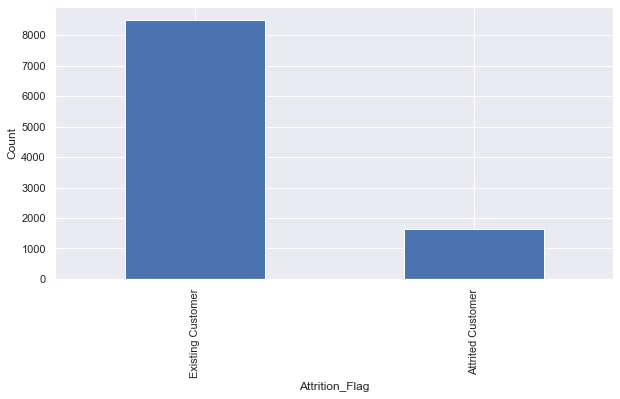

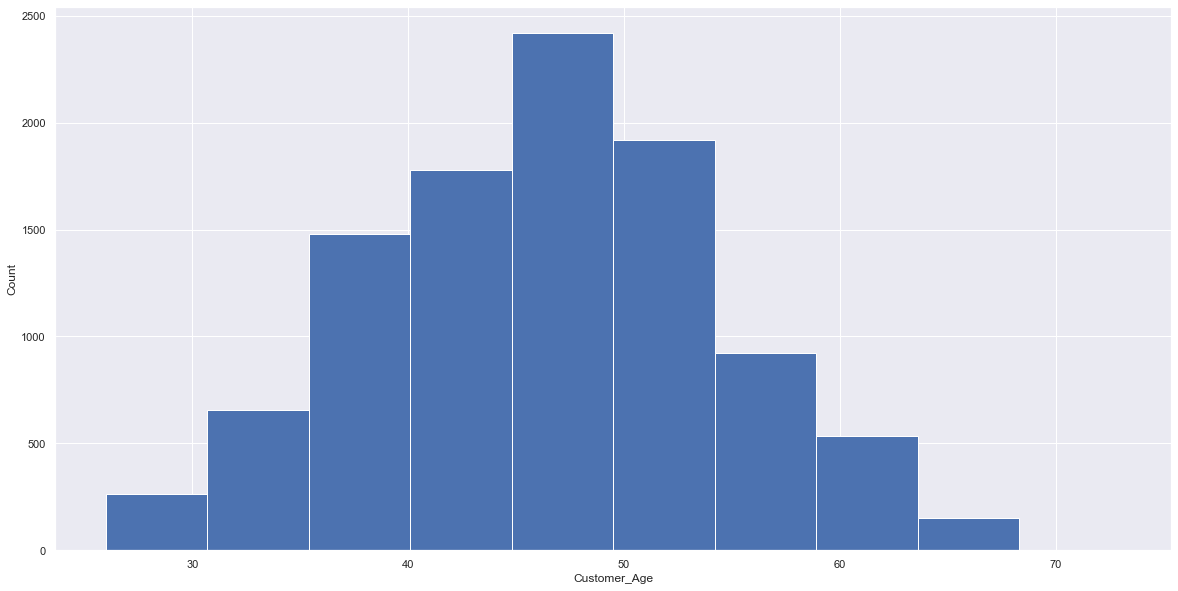

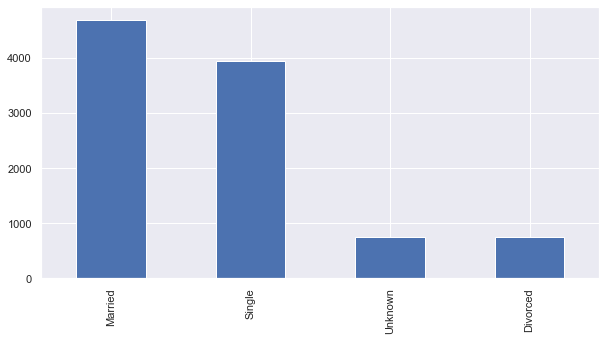

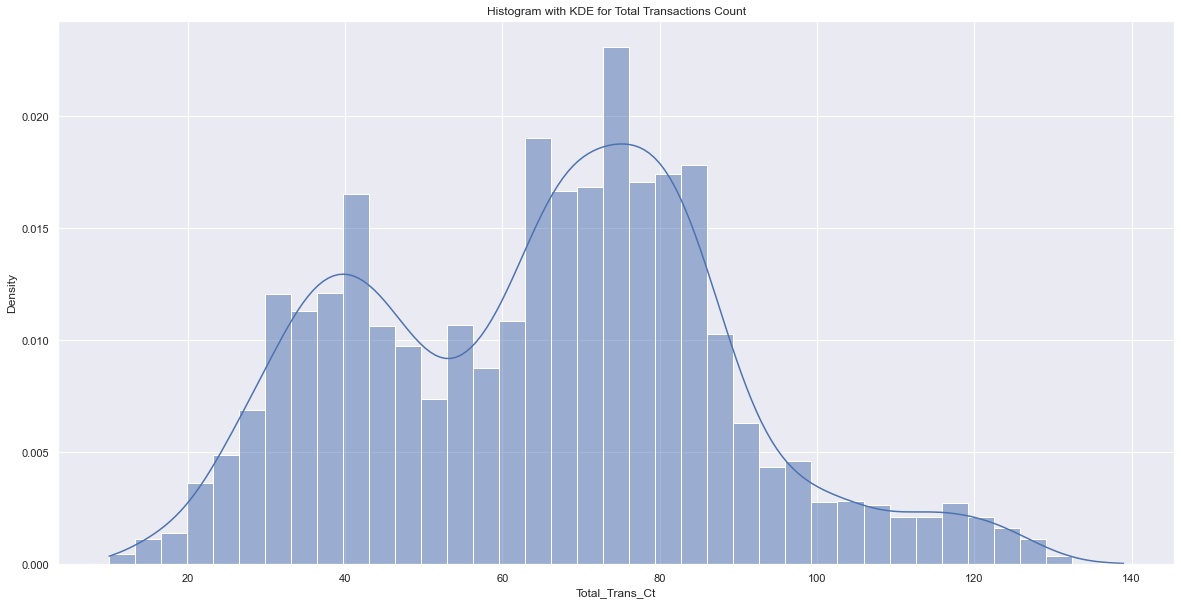

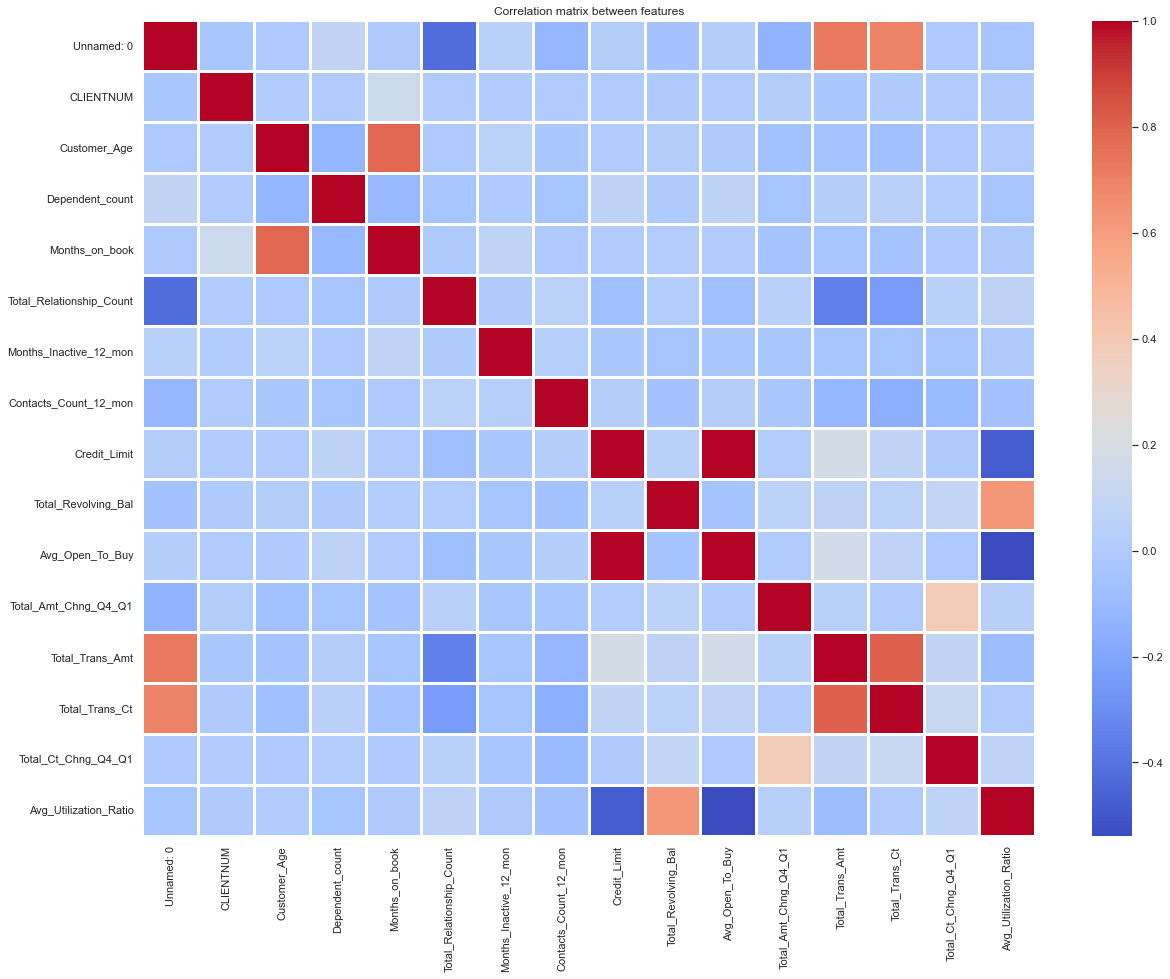

In [23]:
data = joblib.load('data.df.pkl')
data = perform_eda(data)
print(df_num_cols)
print(df_cat_cols)

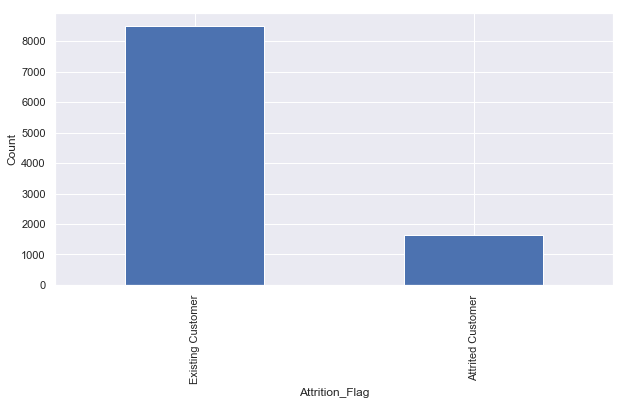

In [18]:
df = joblib.load('data.df.pkl')
plt.figure(figsize=(10, 5))
df['Attrition_Flag'].value_counts().plot(kind='bar')

plt.ylabel('Count')
plt.xlabel('Attrition_Flag')
plt.show()

In [39]:
joblib.dump(data, 'data1.df.pkl')

['data1.df.pkl']

In [8]:

def encoder_helper(df, category_lst, response):
    """
    helper function to turn each categorical column into a new column with
    propotion of churn for each category - associated with cell 15 from the notebook

    input:
            df: pandas dataframe
            category_lst: list of columns that contain categorical features
            response: string of response name [optional argument that could be used for naming variables or index y column]

    output:
            df: pandas dataframe with new columns for
    """

    print(category_lst)

    # generalised encoding logic
    for col_item in category_lst:
        col_lst = []
        col_groups = df.groupby(col_item).mean()[response]

        for val in df[col_item]:
            col_lst.append(col_groups.loc[val])

        print('here....' + col_item + '_' + response)
        df[col_item + '_' + response] = col_lst

    return df


In [46]:
# 3. encoder_helper
print('Calling encoder_helper')
data = joblib.load('data1.df.pkl')
data = encoder_helper(data, df_cat_cols, 'Churn')
print(data.head(5))

Calling encoder_helper
['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
here....Gender_Churn
here....Education_Level_Churn
here....Marital_Status_Churn
here....Income_Category_Churn
here....Card_Category_Churn
   Unnamed: 0  CLIENTNUM     Attrition_Flag  Customer_Age Gender  \
0           0  768805383  Existing Customer            45      M   
1           1  818770008  Existing Customer            49      F   
2           2  713982108  Existing Customer            51      M   
3           3  769911858  Existing Customer            40      F   
4           4  709106358  Existing Customer            40      M   

   Dependent_count Education_Level Marital_Status Income_Category  \
0                3     High School        Married     $60K - $80K   
1                5        Graduate         Single  Less than $40K   
2                3        Graduate        Married    $80K - $120K   
3                4     High School        Unknown  Less than $40K   
4

In [47]:
joblib.dump(data, 'data2.df.pkl')

['data2.df.pkl']

In [9]:
def perform_feature_engineering(df, response):
    """
    input:
              df: pandas dataframe
              response: string of response name [optional argument that could be used for naming variables or index y column]

    output:
              X_train: X training data
              X_test: X testing data
              y_train: y training data
              y_test: y testing data
    """
    y = df['Churn']
    X = pd.DataFrame()
    print(df.columns)
    keep_cols = ['Customer_Age', 'Dependent_count', 'Months_on_book',
                 'Total_Relationship_Count', 'Months_Inactive_12_mon',
                 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
                 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
                 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
                 'Gender_Churn', 'Education_Level_Churn', 'Marital_Status_Churn',
                 'Income_Category_Churn', 'Card_Category_Churn']

    X[keep_cols] = df[keep_cols]
    print(X.head(3))

    # train test split

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # grid search
    rfc = RandomForestClassifier(random_state=42)

    lrc = LogisticRegression(solver='lbfgs', max_iter=3000)

    param_grid = {
        'n_estimators': [200, 500],
        'max_features': ['auto', 'sqrt'],
        'max_depth': [4, 5, 100],
        'criterion': ['gini', 'entropy']
    }

    cv_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
    cv_rfc.fit(X_train, y_train)

    lrc.fit(X_train, y_train)

    y_train_preds_rf = cv_rfc.best_estimator_.predict(X_train)
    y_test_preds_rf = cv_rfc.best_estimator_.predict(X_test)

    y_train_preds_lr = lrc.predict(X_train)
    y_test_preds_lr = lrc.predict(X_test)

    classification_report_image(y_train,
                                y_test,
                                y_train_preds_lr,
                                y_train_preds_rf,
                                y_test_preds_lr,
                                y_test_preds_rf)


In [10]:
def classification_report_image(y_train,
                                y_test,
                                y_train_preds_lr,
                                y_train_preds_rf,
                                y_test_preds_lr,
                                y_test_preds_rf):
    """
    produces classification report for training and testing results and stores report as image
    in images folder
    input:
            y_train: training response values
            y_test:  test response values
            y_train_preds_lr: training predictions from logistic regression
            y_train_preds_rf: training predictions from random forest
            y_test_preds_lr: test predictions from logistic regression
            y_test_preds_rf: test predictions from random forest

    output:
             None
    """
    # scores
    print('random forest results')
    print('test results')
    clr_rf_test = classification_report(y_test, y_test_preds_rf,output_dict=True)
    print(clr_rf_test)

    # save as figure
    plt.figure(figsize=(10,5))
    plt.title('Test set - Classification report for Random Forest')
    sns.heatmap(pd.DataFrame(clr_rf_test).iloc[:-1, :].T, annot=True)  # skip col: support
    plt.savefig(constants.CLR_IMAGE_PATH + '/CLR_RF_test.png', bbox_inches='tight')

    print('train results')
    # print(classification_report(y_train, y_train_preds_rf))
    clr_rf_train = classification_report(y_train, y_train_preds_rf, output_dict=True)
    print(clr_rf_train)

    #save as image file
    plt.figure(figsize=(10,5))
    plt.title('Training set - Classification report for Random Forest')
    sns.heatmap(pd.DataFrame(clr_rf_train).iloc[:-1, :].T, annot=True)
    plt.savefig(constants.CLR_IMAGE_PATH + '/CLR_RF_train.png', bbox_inches='tight')


    print('logistic regression results')
    print('test results')
    # print(classification_report(y_test, y_test_preds_lr))
    clr_lr_test = classification_report(y_test, y_test_preds_lr, output_dict=True)
    print(clr_lr_test)

    # save as figure
    plt.figure(figsize=(10,5))
    plt.title('Test set - Classification report for Logistic Regression')
    sns.heatmap(pd.DataFrame(clr_lr_test).iloc[:-1, :].T, annot=True)
    plt.savefig(constants.CLR_IMAGE_PATH + '/CLR_LR_test.png', bbox_inches='tight')


    print('train results')
    # print(classification_report(y_train, y_train_preds_lr))
    clr_lr_train = classification_report(y_train, y_train_preds_lr, output_dict=True)
    print(clr_lr_train)

    # save as image file
    plt.figure(figsize=(10,5))
    plt.title('Training set - Classification report for Logistic Regression')
    sns.heatmap(pd.DataFrame(clr_lr_train).iloc[:-1, :].T, annot=True)
    plt.savefig(constants.CLR_IMAGE_PATH + '/CLR_LR_train.png', bbox_inches='tight')



In [11]:
%run constants.py

In [12]:
print(constants.EDA_IMAGE_PATH)

./images/eda


In [13]:
import constants

print(dir(constants))

['BANK_DATA_CSV_FILE', 'CLR_IMAGE_PATH', 'EDA_IMAGE_PATH', 'LOG_LEVEL', '__annotations__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__']


Index(['Unnamed: 0', 'CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Churn', 'Gender_Churn', 'Education_Level_Churn',
       'Marital_Status_Churn', 'Income_Category_Churn', 'Card_Category_Churn',
       'Attrition_Flag_Churn'],
      dtype='object')
   Customer_Age  Dependent_count  Months_on_book  Total_Relationship_Count  \
0            45                3              39                         5   
1            49                5              44                         6   
2            51                3              36                         4   

   Months_Inactive_12

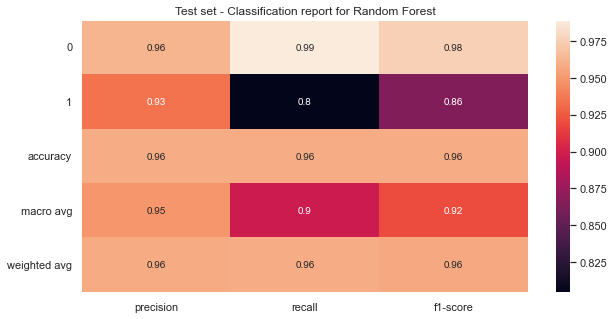

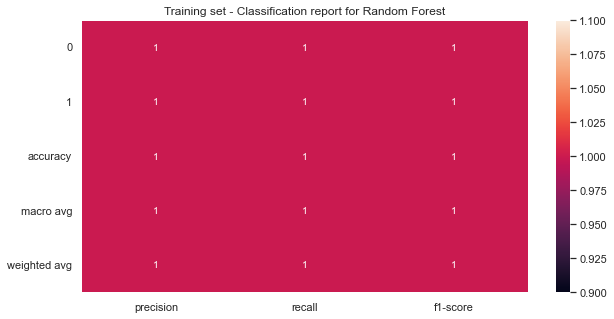

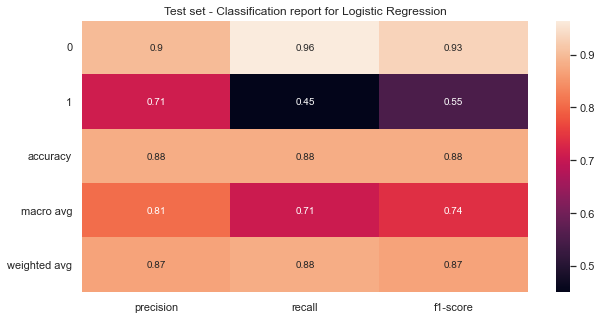

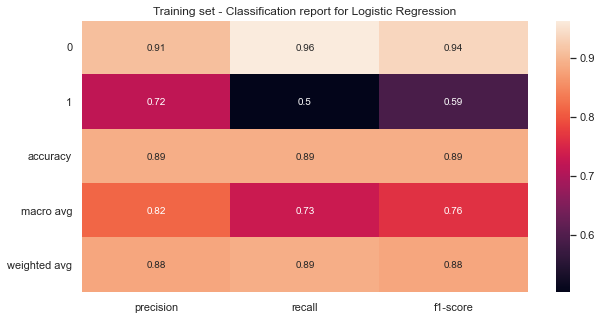

In [14]:
# 4. perform_feature_engineering
data = joblib.load('data2.df.pkl')
perform_feature_engineering(data, 'y')

In [8]:

def feature_importance_plot(model, X_data, output_pth):
    """
    creates and stores the feature importances in pth
    input:
            model: model object containing feature_importances_
            X_data: pandas dataframe of X values
            output_pth: path to store the figure

    output:
             None
    """



def train_models(X_train, X_test, y_train, y_test):
    """
    train, store model results: images + scores, and store models
    input:
              X_train: X training data
              X_test: X testing data
              y_train: y training data
              y_test: y testing data
    output:
              None
    """
    pass



In [11]:
import os
import logging
from logging.handlers import RotatingFileHandler

import constants

if constants.LOG_LEVEL == 'DEBUG':
    log_level = logging.DEBUG
elif constants.LOG_LEVEL == 'INFO':
    log_level = logging.INFO
elif constants.LOG_LEVEL == 'WARNING':
    log_level = logging.WARNING
else:
    log_level = logging.ERROR

logging.basicConfig(
    filename='./logs/churn_library.log',
    level=log_level,
    filemode='w',
    format='%(asctime)s - %(levelname)s - %(filename)s - %(message)s')

def getChurnLogger():
    """
    get logger object
    """
    logger = logging.getLogger()
    return logger
    


In [13]:
logger = getChurnLogger()

In [9]:
#dir(logger)

In [16]:
logger.debug("a")

In [18]:
# Test messages
logger.debug("Harmless debug Message")
logger.info("Just an information")
logger.warning("Its a Warning")
logger.error("Did you try to divide by zero")
logger.critical("Internet is down")

In [20]:
logger.error("addddddddddddddddddd 1")